In [1]:
import os
import sys
from tqdm.notebook import tqdm
import gc

import pandas as pd
import numpy as np
import cv2
import torch
import mmcv
sys.path.append('./mmsegmentation-src')
from mmseg.apis.inference import inference_segmentor, init_segmentor

### Constants

In [6]:
CONFIG = '../configs/swin/upernet_swin_tiny_patch4_window7_512x512_20k_hubmap_multiclass.py'
CHECKPOINT = '../work_dirs/upernet_swin_tiny_patch4_window7_512x512_20k_hubmap_multiclass/latest.pth'
DATA = '../data/hubmap/test_image'
df_sample = pd.read_csv('../data/hubmap/sample_submission.csv').set_index('id')
DEVICE = 'cuda:5'

### rle_encoding

In [3]:
def rle_encode_less_memory(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    This simplified method requires first and last pixel to be zero
    '''
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

### Model

In [4]:
cfg = mmcv.Config.fromfile(CONFIG)
model = init_segmentor(cfg, CHECKPOINT, device=DEVICE)

/workspace/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../work_dirs/upernet_swin_tiny_patch4_window7_512x512_20k_hubmap_multiclass/latest.pth


### Inference

In [9]:
names,preds = [],[]
imgs, pd_mks = [],[]
debug = len(df_sample)<2
for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):
    img = cv2.imread(os.path.join(DATA, str(idx)+'.tiff'))
    pred = inference_segmentor(model, img)[0]
    pred[np.where(pred>0)] = 1
    pred = (pred>0).astype(np.uint8)
    rle = rle_encode_less_memory(pred)

    names.append(str(idx))
    preds.append(rle)
    
    if debug:
        imgs.append(img)
        pd_mks.append(pred)

    del img, pred, rle, idx, row
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

[0 4]
[0 1]


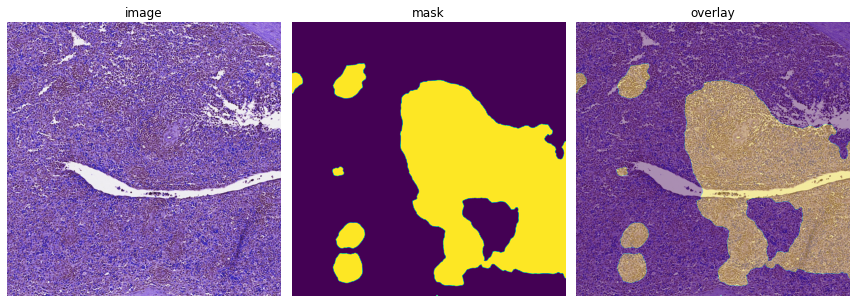

In [8]:
if debug:
    import matplotlib.pyplot as plt
    for img, mask in zip(imgs, pd_mks):
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.axis('OFF'); plt.title('image')
        plt.subplot(1, 3, 2); plt.imshow(mask*255); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img); plt.imshow(mask*255, alpha=0.4); plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()